In [255]:
# imports

from drn_interactions.decoding.plots import EEGDecodeLoader
from drn_interactions.plots.heatmaps import heatmap, state_indicator
from drn_interactions.io import load_derived_generic
from drn_interactions.config import Config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import medfilt
from scipy.stats import zscore
from sklearn.preprocessing import minmax_scale

from scipy.ndimage import gaussian_filter
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest

In [207]:
# sns.set_theme(context="paper", style="ticks")

In [247]:
# loaders and preprocessors

def get_normalized_median_spike_rate_by_neuron_type(
    df_binned_piv,
    medfilt_size=11,
):
    df_binned_piv = df_binned_piv.transform(medfilt, kernel_size=11)
    df_melt = (
        df_binned_piv.reset_index()
        .rename(columns={"bin": "time"})
        .melt(id_vars="time", var_name="neuron_id", value_name="spike_rate")
    )
    df_melt = df_melt.merge(neurons[["neuron_id", "neuron_type"]])
    by_neuron_type = df_melt.groupby(["time", "neuron_type"])
    mean_rate_by_neuron_type = by_neuron_type.spike_rate.mean().reset_index()
    mean_rate_by_neuron_type["norm"] = mean_rate_by_neuron_type.groupby("neuron_type")[
        "spike_rate"
    ].transform(minmax_scale)
    return mean_rate_by_neuron_type


from scipy.ndimage import gaussian_filter1d
from sklearn.feature_extraction.text import TfidfTransformer

def get_session_order(session):
    return neurons.query("session_name == @session").sort_values("neuron_type", ascending=False).neuron_id.astype(str).values.tolist()

def preprocess_spikes_heatmap(spikes: pd.DataFrame, session, gaussian_sigma=None, tf=True, minmax=True) -> pd.DataFrame:
    if gaussian_sigma is not None:
        spikes = spikes.transform(gaussian_filter1d, sigma=gaussian_sigma)
    if tf:
        vals = TfidfTransformer().fit_transform(spikes).todense()
        spikes = pd.DataFrame(vals, columns=spikes.columns, index=spikes.index)
    if minmax:
        spikes = (
            spikes.apply(minmax_scale)
        )
    idx = get_session_order(session)
    spikes =  spikes[[c for c in idx if c in spikes.columns]]
    return spikes.T

def preprocess_spectrogram(df, session_name, remove_outliers=True, zscore_normalize=True):
    # df = df.query("session_name == @session_name")
    # df = df.loc[lambda x: (x.frequency < 8) & (x.frequency > 0)]
    # df = df.pivot(index="timepoint_s", columns="frequency", values="fft_value")

    if remove_outliers:
        idx = IsolationForest().fit_predict(df)
        df.iloc[idx == -1, :] = np.nan 
        df = pd.DataFrame(KNNImputer().fit_transform(df), index=df.index, columns=df.columns)
    
    if zscore_normalize:
        df = df.apply(zscore).transpose().apply(zscore).transpose()
        values = gaussian_filter(df, sigma=(2, 2))
        df = pd.DataFrame(values, index=df.index, columns=df.columns)
    
    df.index = pd.to_timedelta(df.index, unit="s") - pd.to_timedelta(1, unit="s")
    df = df.resample("1s").ffill()
    df.index = df.index.total_seconds()
    return df

In [217]:
# plotters


def plot_spike_rate_by_neuron(df_types, axes, **plot_kwargs):
    for neuron_type, ax in zip(["SR", "SIR", "FF"], axes):
        df_type = df_types.query(f'neuron_type == "{neuron_type}"')
        ax.plot(
            df_type["time"],
            df_type["norm"],
            color="k",
            **plot_kwargs,
            )
        ax.set_ylim(0, 1)
        ax.axis("off")
    return ax


def plot_spikes_heatmap(spikes_heat, ax, **heatmap_kwargs):
    sns.heatmap(spikes_heat, cmap="Greys", ax=ax, cbar=False, **heatmap_kwargs)
    ax.axis("off") 
    return ax

def plot_spectrogram(df, ax, vmin=-1, vmax=1):
    sns.heatmap(df.T.iloc[::-1], cmap="viridis", cbar=False, vmin=vmin, vmax=vmax, ax=ax)
    ax.axis("off")
    return ax

In [201]:
# load data

states = load_derived_generic("eeg_states.csv")
neurons = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "session_name", "neuron_type"]
].assign(neuron_id=lambda x: x.neuron_id.astype(str))
sessions = states.query('quality == "good"').session_name.unique()
print(sessions)


['ESHOCK_07_LOC1' 'ESHOCK_08_LOC1' 'ESHOCK_09_LOC1' 'acute_12' 'acute_16'
 'hamilton_10']


In [248]:
# subset recording and preprocess

loader = EEGDecodeLoader(sessions=sessions)

session = sessions[0]
print(session)


spikes, states, df_fft = loader.load_session_data(session, t_stop=1802)
df_types = get_normalized_median_spike_rate_by_neuron_type(spikes)
spikes_heat = preprocess_spikes_heatmap(spikes, session=session, gaussian_sigma=1, tf=False)
session_spectrogram = preprocess_spectrogram(df_fft, session_name=session)

ESHOCK_07_LOC1


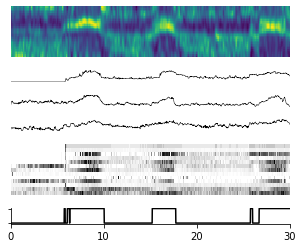

In [265]:
f = plt.figure(figsize=(5, 4))

axes = f.subplots(6, 1, gridspec_kw={
    "hspace": 0.5,
    "height_ratios": [1.4, 0.33, 0.33, 0.33, 1.4, 0.44],
    }, 
    sharex=True)


plot_spectrogram(session_spectrogram, axes[0], vmin=None, vmax=None)

plot_spikes_heatmap(spikes_heat, axes[-2], vmin=0, vmax=1)

plot_spike_rate_by_neuron(df_types, axes=axes[-5:-2], linewidth=0.5)

state_indicator(states, ax=axes[-1], order=["sw", "act"])
axes[-1].set_yticklabels("")

axes[-1].xaxis.set_major_locator(plt.MultipleLocator(600))
axes[-1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x/60:.0f}"))


sns.despine(f, offset=0)

f.savefig(Config.fig_dir / "bs - spike rate - example - post ts.png", 
    dpi=300, bbox_inches="tight", pad_inches=0.05)

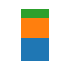

In [257]:
def stacked_bar_single(session, ax):
    neurons["neuron_type"].value_counts().to_frame().T.plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.axis("off")
    return ax

f = plt.figure(figsize=(1, 1))
ax = f.subplots()

stacked_bar_single(session, ax)

f.savefig(Config.fig_dir / "bs - spike rate - example - neuron types key.png", 
    dpi=100, bbox_inches="tight", pad_inches=0.05)

In [80]:
# plots
# - spectrogram
# - spike rate by neuron type
# - Neuron heatmap
# - State Inhidicator